In [1]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]
from IPython import display
%matplotlib inline
import gymnasium as gym
import torch
import time


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 82.8 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=495184 sha256=cb546d82887cb7df70346e9a11ce58cce1cebaeefc9d535e736a3353ba9ede6b
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
from PIL import Image
import numpy as np
def display_image(imageArray):
    display.display(Image.fromarray(np.array(imageArray),'RGB'),clear=True)

In [3]:
from collections import namedtuple
Tr  = namedtuple('Transition', ('state','action', 'next_state','reward'))

In [4]:
NUM_DIZITIZED = 6
def reset(env):
      observation = env.reset()[0]
      s_a_history = [[observation, np.nan]]
      pi = [0.5,0.5]
      return observation, s_a_history, pi
def bins(clip_min, clip_max, num):
    return np.linspace(clip_min, clip_max, num + 1)[1:-1]

def digitize_state(observation):
    cart_pos, cart_v, pole_angle, pole_v = observation
    digitized = [
        np.digitize(cart_pos, bins=bins(-2.4, 2.4, NUM_DIZITIZED)),
        np.digitize(cart_v, bins=bins(-3.0, 3.0, NUM_DIZITIZED)),
        np.digitize(pole_angle, bins=bins(-0.5, 0.5, NUM_DIZITIZED)),
        np.digitize(pole_v, bins=bins(-2.0, 2.0, NUM_DIZITIZED))
    ]
    return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])

def get_action(s,Q,epsilon, pi=[0.5,0.5]):
    state = digitize_state(s)
    if np.random.rand() < epsilon:
        action = np.random.choice([0,1])
    else:
        action = np.argmax(Q[state])
    return action

def Q_learning(s, a, r, s_next, Q, eta, gamma, is_terminated):
    s = digitize_state(s)
    s_next = digitize_state(s_next)
    if is_terminated:
        Q[s, a] = Q[s, a] + eta * (r- Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a])
    return Q

def run_once(env, s_a_history,initial_observation, Q, epsilon, eta, gamma, pi, show=False):
    observation = initial_observation
    s = observation
    a = get_action(s, Q, epsilon, pi)
    a_next = a
    count = 0;
    while True:
        is_terminated = False
        if show:
            time.sleep(0.01)
            img = env.render()
            display_image(img)
        a = a_next
        s_a_history[-1][1] = a
        s_next, reward, terminated, truncated, info = env.step(a)
        s_a_history.append([s_next, np.nan])
        if count > 500:
            r = 1
            a_next = np.nan
            is_terminated = True
        elif count < 500 and terminated:
            r = -1
            a_next = np.nan
            is_terminated = True
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma, is_terminated)
        if is_terminated:
            if show:
                time.sleep(0.01)
                img = env.render()
                display_image(img)
            break
        else:
            s = s_next
        count += 1
    return [s_a_history, Q]

In [5]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
eta = 0.1
gamma = 0.9
epsilon = 0.5
Q = np.random.rand(NUM_DIZITIZED**4,2)
v = np.nanmax(Q, axis=1)
is_continue = True
episode = 1
env.reset()
while is_continue:
    observation, s_a_history, pi = reset(env)
    #print('episode: ' + str(episode))
    epsilon = epsilon / 2
    [s_a_history, Q] = run_once(env, s_a_history, observation, Q, epsilon, eta, gamma, pi,show=False)
    new_v = np.nanmax(Q, axis=1)
    #print(np.sum(np.abs(new_v - v)))
    v = new_v
    episode = episode + 1
    if episode > 1000:
        break
print(np.sum(np.abs(new_v - v)))
env.close()

0.0


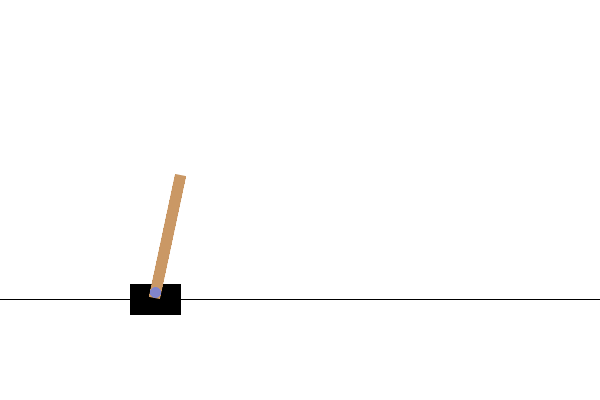

[[[array([-0.0478007 , -0.02060678, -0.04591105, -0.03613169], dtype=float32),
   0],
  [array([-0.04821283, -0.21504132, -0.04663368,  0.2417197 ], dtype=float32),
   0],
  [array([-0.05251366, -0.4094672 , -0.04179928,  0.5193361 ], dtype=float32),
   0],
  [array([-0.06070301, -0.6039765 , -0.03141256,  0.79855984], dtype=float32),
   1],
  [array([-0.07278253, -0.408438  , -0.01544137,  0.496163  ], dtype=float32),
   0],
  [array([-0.0809513 , -0.60333884, -0.00551811,  0.78393984], dtype=float32),
   1],
  [array([-0.09301807, -0.40814152,  0.01016069,  0.48952597], dtype=float32),
   1],
  [array([-0.1011809 , -0.21316436,  0.01995121,  0.20006253], dtype=float32),
   1],
  [array([-0.10544419, -0.01833336,  0.02395246, -0.08626054], dtype=float32),
   1],
  [array([-0.10581086,  0.1764372 ,  0.02222725, -0.37129125], dtype=float32),
   1],
  [array([-0.10228211,  0.37123644,  0.01480142, -0.65688366], dtype=float32),
   1],
  [array([-0.09485739,  0.56614923,  0.00166375, -0.94

In [6]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env.reset()
observation, s_a_history, pi = reset(env)
run_once(env, s_a_history, observation, Q, 0, eta, gamma, pi,show=True)